In [4]:
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import glob
import re

In [5]:
def data_raw_to_data(data_raw, data_option):
    plot_option = data_option #1 = Signal1, 2 = Signal2, 3 = delta of signals
    err = None

    #Choose what to plot
    if plot_option == 3:
        data = data_raw[1] - data_raw[2]
        shift = (data_raw.shape[0]-1)//2
        err1 = abs(data_raw[1+shift])
        err2 = abs(data_raw[2+shift])
        err = err1+err2
    else:
        data = data_raw[plot_option]
        shift = (data_raw.shape[0]-1)//2
        err = data_raw[plot_option+shift]
        
    return data, err

def remove_suffix(input_string, suffix):
    if suffix and input_string.endswith(suffix):
        return input_string[:-len(suffix)]
    return input_string

def remove_prefix(input_string, prefix):
    if prefix and input_string.startswith(prefix):
        return input_string[len(prefix):]
    return input_string

In [6]:
directory = 'G:\\Data\\Qudi_Data\\2024\\07\\20240712\\PulsedMeasurement\\'
path = directory + '20240712-1628-59_Hecho-correlation-alt-phased-exp_A-H12-13_NbSe2_S4_rot_2K_70mT_Bnv_OOC__Hahnechowaitingtime=1.7e-06s_correlation_test_pulsed_measurement'+'.dat'
filelabel = remove_suffix(path,'_pulsed_measurement.dat')
filelabel = remove_prefix(filelabel,directory)+'_analysis'

In [15]:
data_raw = np.loadtxt(path).T
data, err = data_raw_to_data(data_raw, 3)

var_list = data_raw[0]
lin_points = 1000000000
indices = np.unique(np.geomspace(1,lin_points,len(var_list)).astype(int))-1
print(indices)
var_new = np.linspace(var_list[0], var_list[-1], lin_points)
data_new = np.zeros_like(var_new)
print(len(var_list), len(indices))
data_new[indices] = data
var_list = var_new
data = data_new

[        0         1         2         4         6         9        14
        20        28        40        57        81       115       162
       228       321       451       634       891      1253      1760
      2473      3474      4880      6854      9628     13524     18996
     26681     37476     52638     73934    103845    145858    204867
    287749    404162    567672    797331   1119901   1572972   2209337
   3103152   4358571   6121885   8598568  12077225  16963215  23825891
  33464947  47003601  66019483  92728473 130242911 182934273 256942570
 360891827 506895028 711965608 999999999]


Traceback (most recent call last):
  File "C:\Users\yy3\Documents\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-5a2f5a7914f0>", line 11, in <module>
    data_new[indices] = data
ValueError: shape mismatch: value array of shape (62,) could not be broadcast to indexing result of shape (60,)


62 60


In [28]:
data_raw = np.loadtxt(path).T
data, err = data_raw_to_data(data_raw, 3)

var_list = data_raw[0]
delta = var_list[1]-var_list[0]
var_new = np.arange(var_list[0], var_list[-1]+delta, delta)

def find_nearest(value, array):
    idx = np.searchsorted(array, value, side="left")
    cond = np.logical_and(idx>0, np.logical_or(idx == len(array), np.fabs(value - array[idx-1]) < np.fabs(value - array[idx])))
    return np.where(cond, array[idx-1], array[idx])

var_new_values = find_nearest(var_list, var_new)
indices = np.where(np.in1d(var_new, var_new_values))[0]
indices

data_new = np.zeros_like(var_new)
data_new[indices] = data
var_list = var_new
data = data_new

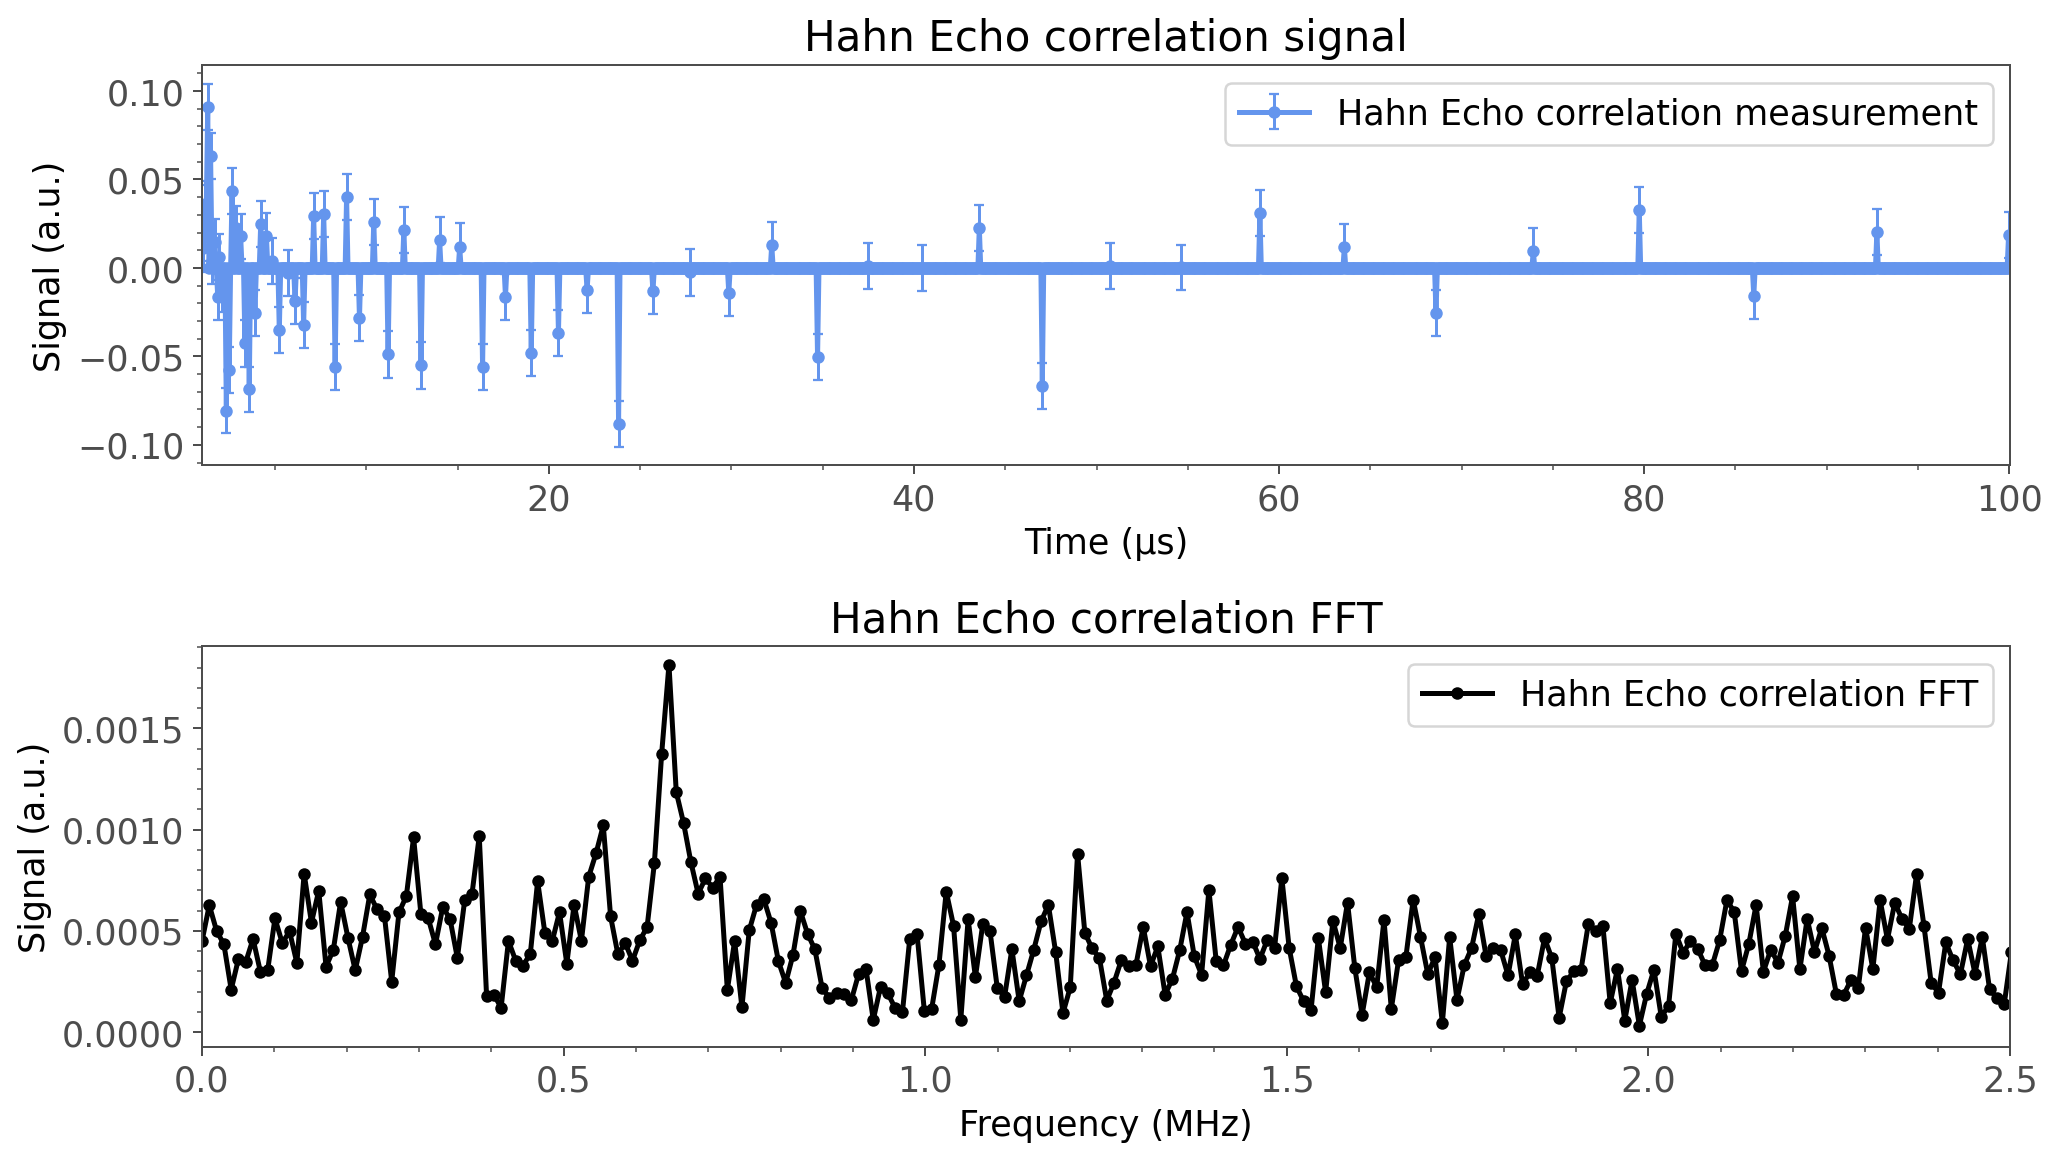

In [35]:
fig = plt.figure(figsize=(35/3,20/3))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
# ax1.set_xscale('log')
# ax2.set_xscale('log')

data_raw = np.loadtxt(path).T
data, err = data_raw_to_data(data_raw, 3)

var_list = data_raw[0]
delta = var_list[1]-var_list[0]
var_new = np.arange(var_list[0], var_list[-1]+delta, delta)

def find_nearest(value, array):
    idx = np.searchsorted(array, value, side="left")
    cond = np.logical_and(idx>0, np.logical_or(idx == len(array), np.fabs(value - array[idx-1]) < np.fabs(value - array[idx])))
    return np.where(cond, array[idx-1], array[idx])

var_new_values = find_nearest(var_list, var_new)
indices = np.where(np.in1d(var_new, var_new_values))[0]
indices

data_new = np.zeros_like(var_new)
err_new = np.zeros_like(var_new)
data_new[indices] = data
err_new[indices] = err
var_list = var_new
data = data_new
err = err_new

ax1.errorbar(x=var_list*1e6, y=data,
                         yerr=err, fmt='-o',
                         capsize=2, capthick=0.9,
                        elinewidth=1.2, label=f'Hahn Echo correlation measurement', color='cornflowerblue')

N = len(var_list)
T = var_list[1]-var_list[0]
fft_data = fft(data)
fft_freq = fftfreq(N, T)[:N//2]

ax2.errorbar(x=fft_freq/1e6, y=2.0/N * np.abs(fft_data[0:N//2]), fmt='-o',
                         capsize=2, capthick=0.9,
                        elinewidth=1.2, label=f'Hahn Echo correlation FFT', color='black')


ax1.title.set_text('Hahn Echo correlation signal')
ax2.title.set_text('Hahn Echo correlation FFT')

ax1.set_xlabel('Time (µs)')
ax1.set_ylabel('Signal (a.u.)')
ax2.set_xlabel('Frequency (MHz)')
ax2.set_ylabel('Signal (a.u.)')

# freq = 0.384
# ax2.vlines(freq,0,0.15)
# ax2.text(freq+0.01, 0.05,f'{freq} MHz')
# freq = 1.714
# ax2.vlines(freq,0,0.15)
# ax2.text(freq+0.01, 0.05,f'{freq} MHz')

ax1.set_xlim([var_list[0]*1e6,var_list[-1]*1e6])
ax2.set_xlim([0,2.5])

ax1.legend()
ax2.legend()


fontsize = 20
plt.tight_layout()

with open(directory+filelabel+'.png', 'wb') as f:
    plt.savefig(f,format='png')
plt.show()

In [53]:
0.384/0.06*7.04925

45.1152

In [48]:
0.65/10.705

0.06071929005137786

In [51]:
3.077/3 *0.06

0.061540000000000004